# PREDICTING DROP OUT RATE OF STUDENTS FROM ONLINE COURSES

Massive Open Online Course (MOOC) strives to take education to next level by providing easy access to course materials through Internet. MOOC scales well compared to traditional schools thanks to the availability of the materials and the reach it can have. Since there is almost no cost to register to a course, the dropout rate is usually high. The completion rate on Coursera is only 7%-9% (Wiki link). The study summarizes the dropout rate spikes after the first week of the course commencement. Studying MOOC dropouts can help to reducing dropout rate and boost the values of MOOC. Better understanding dropout behaviors can also help improving MOOC content/websites to help students complete the course successfully. 
Data set for this course is from http://kddcup2015.com/information.html. 
Main data sets are –
1.	Enrollments – This data set contains the enrollment information of a student. Precisely it has Student and course identifier which marks a unique enrollment. 
2.	Objects – This data set contains module in a course with its category, children objects and release time. Those modules represent different online materials of the courses, e.g., chapters, videos, problem sets and etc. The modules are organized as a tree, i.e., each course contains several chapters; each chapter contains several sections; and each section contains several objects (videos, problem sets, and etc).
3.	Event Logs – This data set captures the behavior of a student. What action was made by a specific student at a specific instance of time. 
Main challenge will be to model the event logs data (which is a predominant problem that is being solved in companies like LinkedIn, Facebook). 


In [3]:
%matplotlib inline
import numpy as np
import scipy as sp

import pandas as pd

# special matplotlib argument for improved plots
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import  grid_search
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm


from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


# Introduction - Following section reads the training and test data

In [4]:
data =  pd.read_csv(r".\Data\corpus_v4.tsv", sep='\t')
data_full = pd.read_csv("./Data/JoinedLogs_TrainTest.tsv", sep='\t')
data_joined = data.join(data_full[['eid', 'cid', 'uid']] , how='left' , on ='eid' , rsuffix='_right' )

sample = data_full
sample['time'] = sample['time'].apply(lambda t: int(t))
sample['hour'] = sample['time'].apply(lambda x: int(x / 3600))
sample['day']  = sample['hour'].apply(lambda x: int(x / 24))
sample['week'] = sample['day'].apply(lambda x: int(x / 7))
s = sample.groupby('eid').week.min()

def week(x):
    return s[x]
sample['start_week'] = sample['eid'].apply(week)
sample['week_relative_start'] = sample['week'] - sample['start_week']

s = sample.groupby(['eid','week_relative_start'])['obj'].nunique()
s1= s.unstack('week_relative_start')
s2 = s1.reset_index()
s2_no_na = s2.fillna(0)
s2_no_na.columns = ['eid' , 'week0_obj' ,'week1_obj' ,'week2_obj' ,'week3_obj' ,'week4_obj' ,'week5_obj']
data= pd.merge(data , s2_no_na , left_on='eid' , right_on='eid')
dropout = data[data.churn_label ==1]
no_dropout = data [data.churn_label == 0]

In [ ]:
print ('Total # of enrollments', len(data))
print('Total # of drop outs' , len(dropout))
print('Total # of non drop outs' , len(no_dropout))

# Feature Selection
This section creates a subset of meaningful features from the ones that were created by auto featurizer.
Following steps were taken to featurize the data
1. Created an auto featurizer which groups and creates aggregations for enrollments with respect to different events. ( Details    are in Featurizer notebook in the same folder)
2. Once the features ( total 600) are created - We can hand pick the relevant ones and create a subset which can further be        analyzed.
3. I wanted to create the model which can be used by the MOOC platforms to reduce their dropouts. So the goal is to identify        whether the student will dropout or not during the course. Hence it will be a good idea to create a model without the            enrollment details in the training set to see how it performs. That is the features_no_enrollment_data.
4. Find the pearson's correlation coefficient between the features and target variables. Pick out the top 100 features which are    highly corelated with target and then apply further filters.

In [63]:
#adding hour_of_week_unique
features_2 =[      'key=eid|cat=video|time_count','key=eid|obj_unique','key=eid|src_evt=server|access|time_count'
                  ,'key=eid|time_count'
                  ,'key=eid|hour_unique'
                  ,'key=eid|src_evt=server|problem|time_count'
                  ,'week0_obj'
                  ,'week1_obj'
                  ,'week2_obj'
                  ,'key=uid|hour_unique'
                  ,'key=uid|cid_unique'
                  ,'key=uid|cat=problem|time_count'
                  ,'key=uid|cat=video|time_count'
                  ,'key=uid|obj_unique'
                  ,'key=uid|src_evt=browser|access|time_count'
                  ,'key=cid|obj_unique'
               
            ]

features = features_2
#features_no_enrollment_data - these features are the ones which does not have current enrollment details. 
# this is used to check if we can predict if a student will drop out with his/her past activities and the current course's history 
#along with first 2 weeks of activity alone for the enrollment.
features_no_enrollment_data= ['week0_obj'
                  ,'week1_obj'
                  ,'week2_obj'
                  ,'key=uid|hour_unique'
                  ,'key=uid|cid_unique'
                  ,'key=uid|cat=problem|time_count'
                  ,'key=uid|cat=video|time_count'
                  ,'key=uid|obj_unique'
                  ,'key=uid|src_evt=browser|access|time_count'
                  ,'key=cid|hour_unique'
                  ,'key=cid|cat=problem|time_count'
                  ,'key=cid|cat=video|time_count'
                  ,'key=cid|obj_unique'
            ]

########################Following section creates features which are highly corelated with target variables################
corr = data.corr()
correlation = corr['churn_label']
correlation = 1 - abs(correlation)
a = correlation.sort_values()
b =a[0:100]
features_high_corr = b.index
features_high_corr =features_high_corr.delete(0)
##########################################################################################################################

# General Classification function - which takes the classifier , data and creates a model

In [68]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y
#score_func - can be accuracy , F1 score etc. 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("Best params " ,gs.best_params_ )
    print("Best score " ,gs.best_score_ )
   
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None
                , reuse_split=None, score_func=None, n_folds=5, n_jobs=1 , standardize = False, train_size = .8 , over_sampling = False):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    ros = RandomOverSampler()
    if mask !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    
    if(mask==None and reuse_split== None):
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size , stratify =y)
    if over_sampling == True:
        Xtrain, ytrain = ros.fit_sample(Xtrain, ytrain)
    
    if parameters!= None:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

# Logistic Regression model

In [69]:
print("##########Logistic Regression model on features including enrollement details############################")
clf_l, Xtrain, ytrain, Xtest, ytest  = do_classify(LogisticRegression(n_jobs  = -1), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, features, 'churn_label',0)
print ('AUC Score is ',GetAUCScore(clf_l))

print("##########Logistic Regression model on features without including enrollement details############################")  
clf_l, Xtrain, ytrain, Xtest, ytest  = do_classify(LogisticRegression(n_jobs  = -1), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, features_no_enrollment_data, 'churn_label',0)
print ('AUC Score is ',GetAUCScore(clf_l))

print("##########Logistic Regression model on features with highly correlated variables with target############################")  
clf_l, Xtrain, ytrain, Xtest, ytest  = do_classify(LogisticRegression(n_jobs  = -1), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, features_high_corr, 'churn_label',0)

      

##########Logistic Regression model on features including enrollement details############################
Best params  {'C': 0.01}
Best score  0.86401957836
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[18472   645]
 [ 2632  2360]]
########################################################
AUC Score is  0.850381020786
##########Logistic Regression model on features without including enrollement details############################
Best params  {'C': 1}
Best score  0.847842543528
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.85
[[18378   739]
 [ 2899  2093]]
########################################################
AUC Score is  0.83372029971
##########Logistic Regression model on features with highly correlated variables with target############################
Best params  {'C': 1}
Best score  0.871879958106
############# based on standard pre

# Decision Tree Classfier

##########DecisionTreeClassifier model on features including enrollement details############################
Best params  {'max_depth': 1, 'min_samples_leaf': 1}
Best score  0.62635888656
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.85
[[17597  1520]
 [ 2023  2969]]
########################################################
AUC Score is  0.757620609568


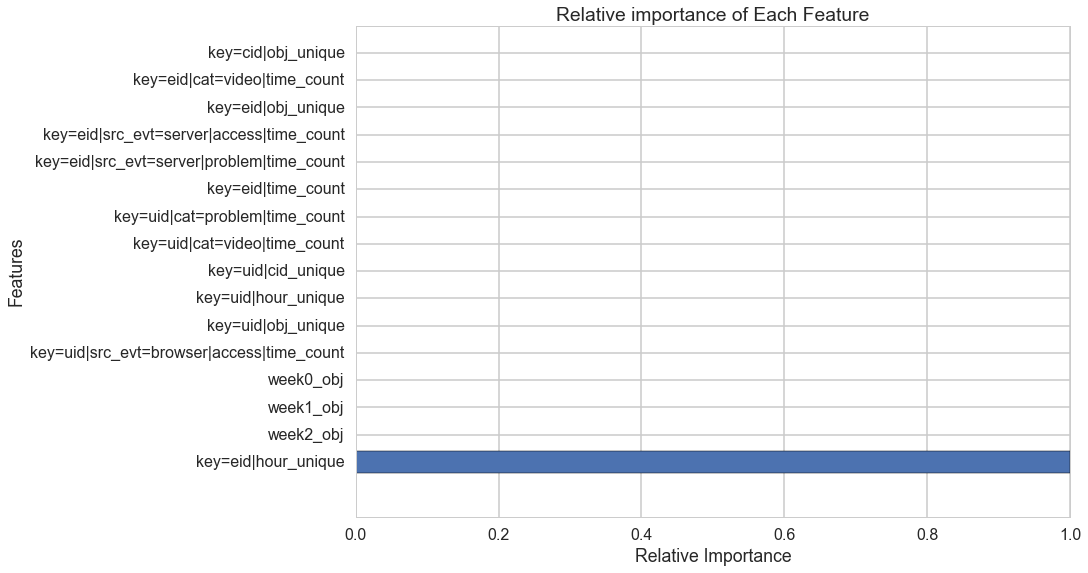

##########DecisionTreeClassifier model on features without  including enrollement details############################
Best params  {'max_depth': 7, 'min_samples_leaf': 4}
Best score  0.591713481322
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[18097  1020]
 [ 2418  2574]]
########################################################
AUC Score is  0.854478983081


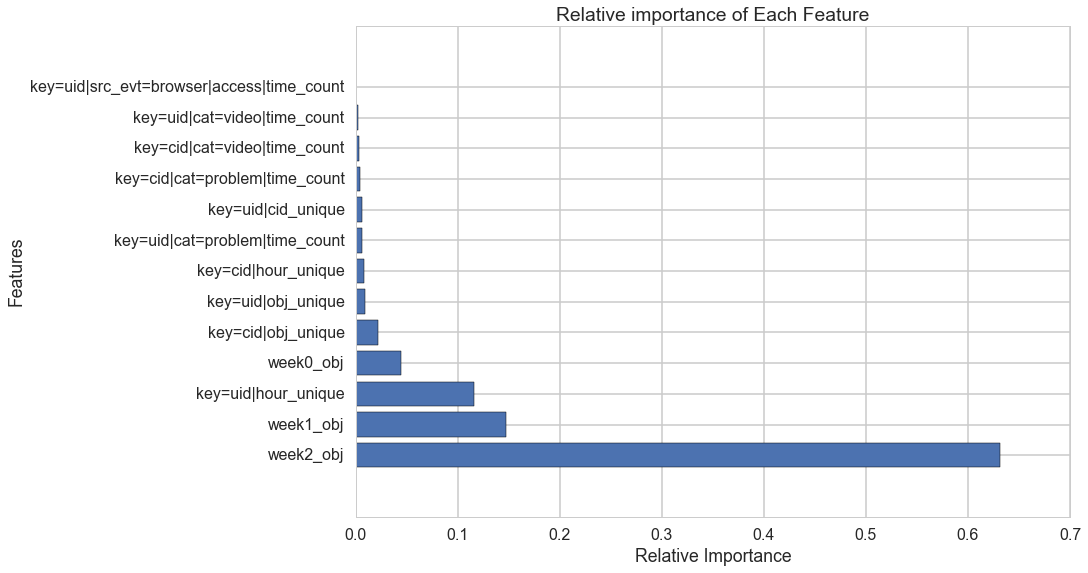

##########DecisionTreeClassifier model on features with highly correlated with target############################
Best params  {'max_depth': 5, 'min_samples_leaf': 6}
Best score  0.647103464981
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.88
[[18264   853]
 [ 2138  2854]]
########################################################
AUC Score is  0.876134251901


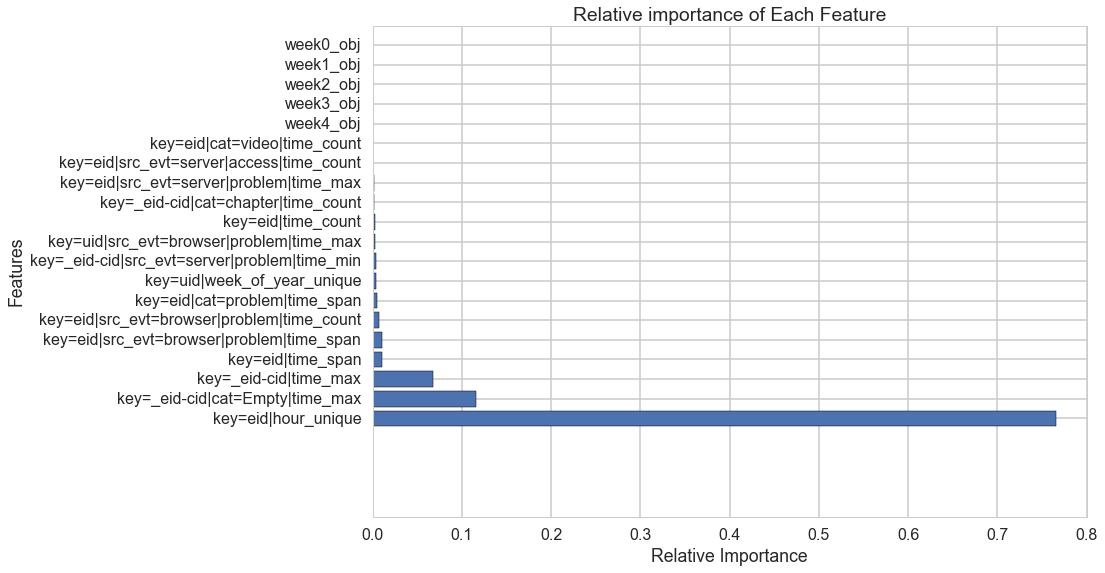

In [70]:
print("##########DecisionTreeClassifier model on features including enrollement details############################")
clfTree1 = tree.DecisionTreeClassifier()
parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1,parameters, data, 
                                                     features,'churn_label',0, 
                                                     n_jobs = 4, score_func = 'f1')
print ('AUC Score is ',GetAUCScore(clfTree1))
feature_importances(clfTree1 , features)
print("##########DecisionTreeClassifier model on features without  including enrollement details############################")
clfTree1 = tree.DecisionTreeClassifier()
parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1,parameters, data, 
                                                     features_no_enrollment_data,'churn_label',0, 
                                                     n_jobs = 4, score_func = 'f1')
print ('AUC Score is ',GetAUCScore(clfTree1 ))
feature_importances(clfTree1, features_no_enrollment_data)  

print("##########DecisionTreeClassifier model on features with highly correlated with target############################")
clfTree1 = tree.DecisionTreeClassifier()
parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1,parameters, data, 
                                                     features_high_corr,'churn_label',0, 
                                                     n_jobs = 4, score_func = 'f1')
print ('AUC Score is ',GetAUCScore(clfTree1 ))
feature_importances(clfTree1, features_high_corr, 20)    
      

# Random Forest Classifier

##########RandomForestClassifier model on features including enrollement details############################
Best params  {'n_estimators': 59}
Best score  0.626182816116
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.86
[[18185   932]
 [ 2384  2608]]
########################################################
AUC Score is  0.850107988862


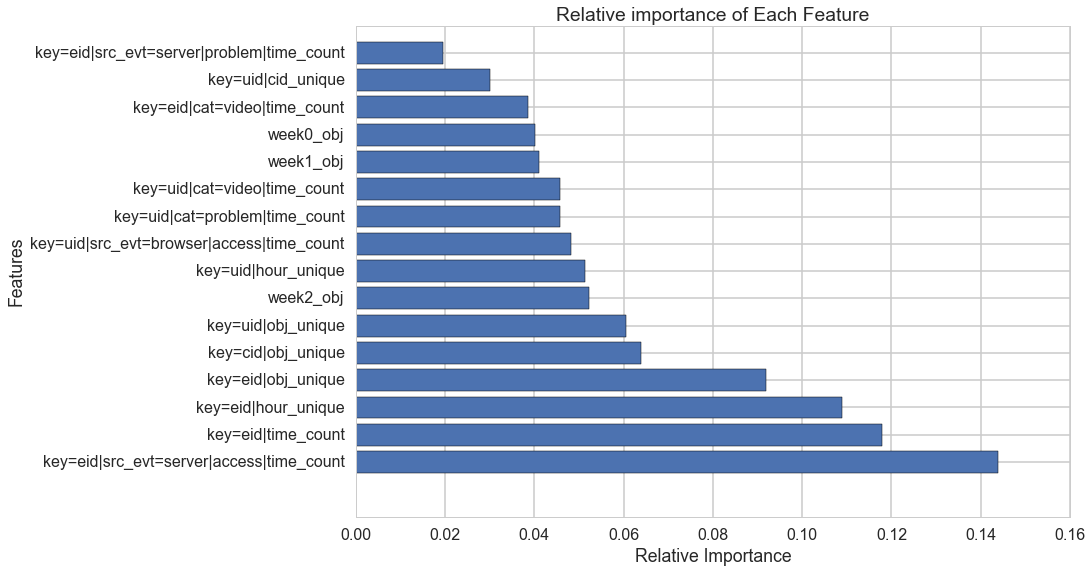

##########RandomForestClassifier model on features without including enrollement details############################
Best params  {'n_estimators': 59}
Best score  0.605222983054
############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.86
[[18150   967]
 [ 2468  2524]]
########################################################
AUC Score is  0.84570742387


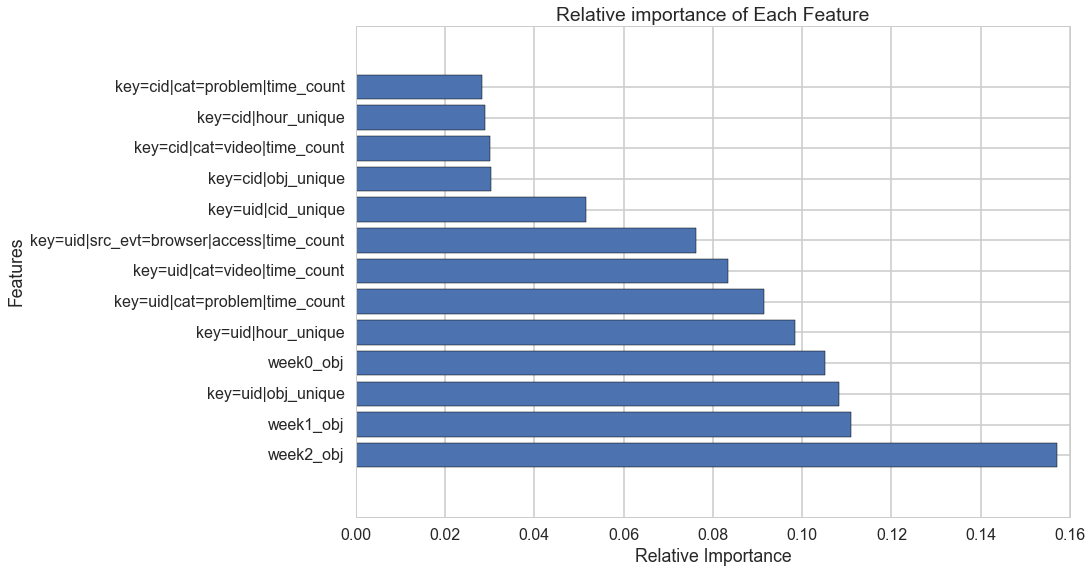

##########RandomForestClassifier model on features which are highly corelated############################
Best params  {'n_estimators': 57}
Best score  0.666027813907
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.87
[[18187   930]
 [ 2098  2894]]
########################################################
AUC Score is  0.876423415719


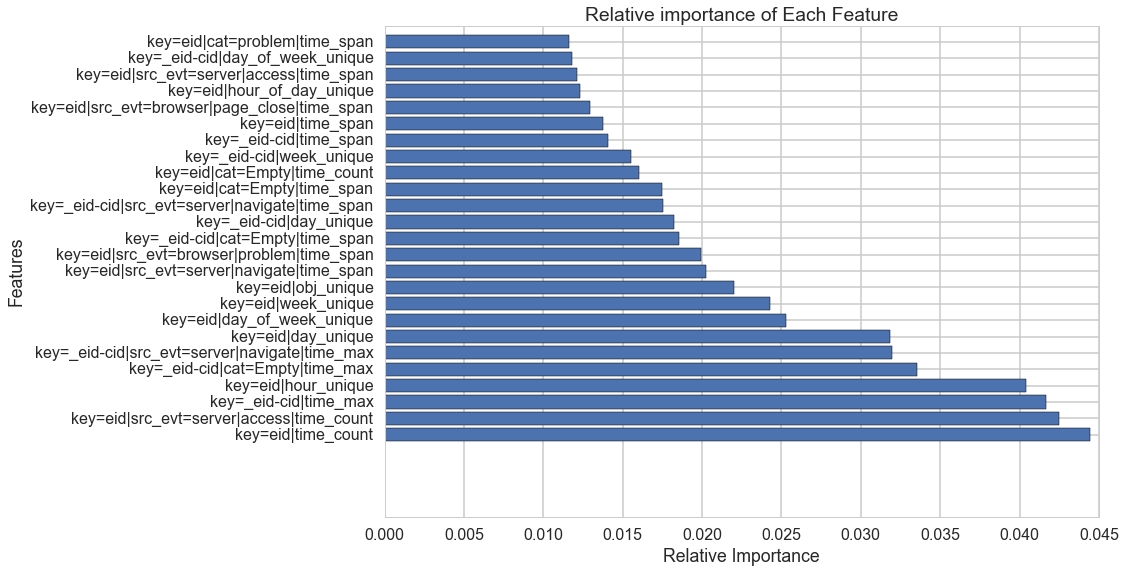

##########RandomForestClassifier model on features_high_corr and  over sampling############################
Best params  {'n_estimators': 56}
Best score  0.960884157714
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.88
[[18002  1115]
 [ 1878  3114]]
########################################################
AUC Score is  0.879259726584


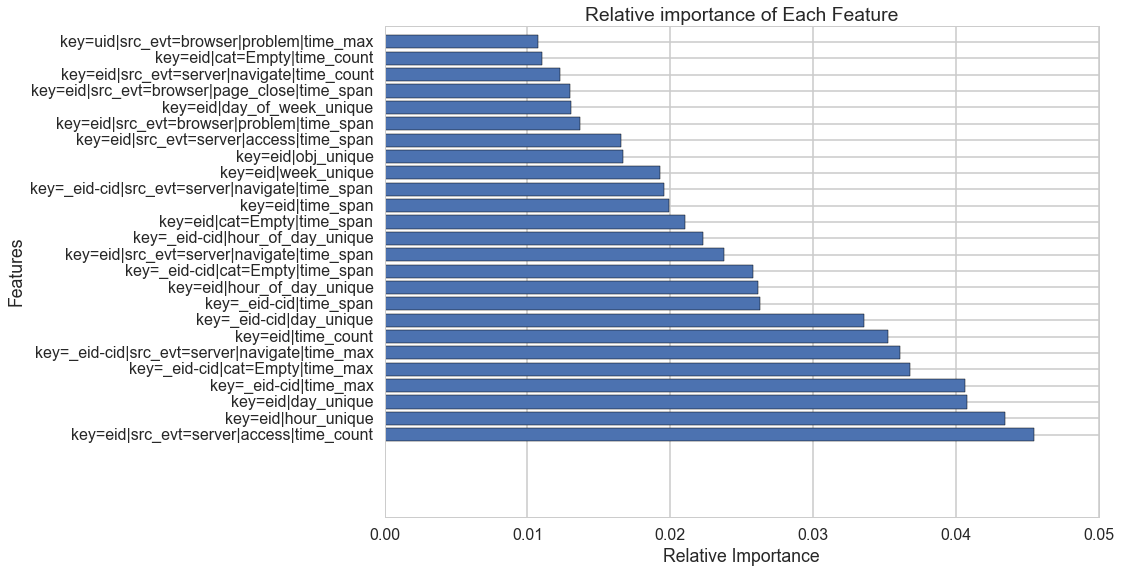

In [71]:
print("##########RandomForestClassifier model on features including enrollement details############################")
estimators = [x+1 for x in range(60)]

clfForest = RandomForestClassifier()
parameters = { "n_estimators": estimators }
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest,parameters, data, 
                                                     features,'churn_label',0, 
                                                     n_jobs = -1, score_func = 'f1')
print ('AUC Score is ',GetAUCScore(clfForest))
feature_importances(clfForest, features)
      
print("##########RandomForestClassifier model on features without including enrollement details############################")
estimators = [x+1 for x in range(60)]

clfForest = RandomForestClassifier()
parameters = { "n_estimators": estimators }
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest,parameters, data, 
                                                     features_no_enrollment_data,'churn_label',0, 
                                                     n_jobs = -1, score_func = 'f1')
print ('AUC Score is ',GetAUCScore(clfForest))
feature_importances(clfForest , features_no_enrollment_data)      


print("##########RandomForestClassifier model on features which are highly corelated############################")
estimators = [x+1 for x in range(60)]
clfForest = RandomForestClassifier()
parameters = { "n_estimators": estimators }
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest,parameters, data, 
                                                     features_high_corr,'churn_label',0, 
                                                     n_jobs = -1, score_func = 'f1')#, over_sampling = True)
print ('AUC Score is ',GetAUCScore(clfForest))
feature_importances(clfForest, features_high_corr, 25)



print("##########RandomForestClassifier model on features_high_corr and  over sampling############################")
estimators = [x+1 for x in range(60)]

clfForest = RandomForestClassifier()
parameters = { "n_estimators": estimators }
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest,parameters, data, 
                                                     features_high_corr,'churn_label',0, 
                                                     n_jobs = -1, score_func = 'f1', over_sampling = True)

print ('AUC Score is ',GetAUCScore(clfForest))
feature_importances(clfForest, features_high_corr , 25)

##########Ada boost Classifier model on features including enrollement details with hihgly correlated features with target############################
Best params  {'n_estimators': 59}
Best score  0.659209150722
############# based on standard predict ################
Accuracy on training data: 0.88
Accuracy on test data:     0.88
[[18245   872]
 [ 2095  2897]]
########################################################
AUC Score is  0.886645897127


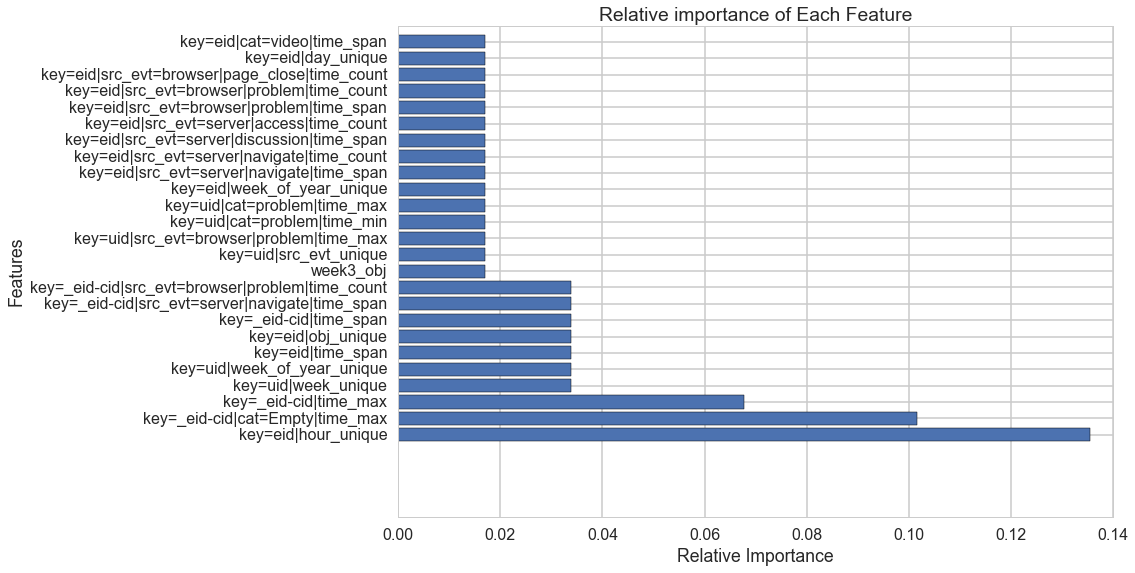

##########Ada boost Classifier model on features including enrollement details with hihgly correlated features with target and over sampling############################
Best params  {'n_estimators': 57}
Best score  0.801659699889
############# based on standard predict ################
Accuracy on training data: 0.81
Accuracy on test data:     0.83
[[16207  2910]
 [ 1149  3843]]
########################################################
AUC Score is  0.885693827182


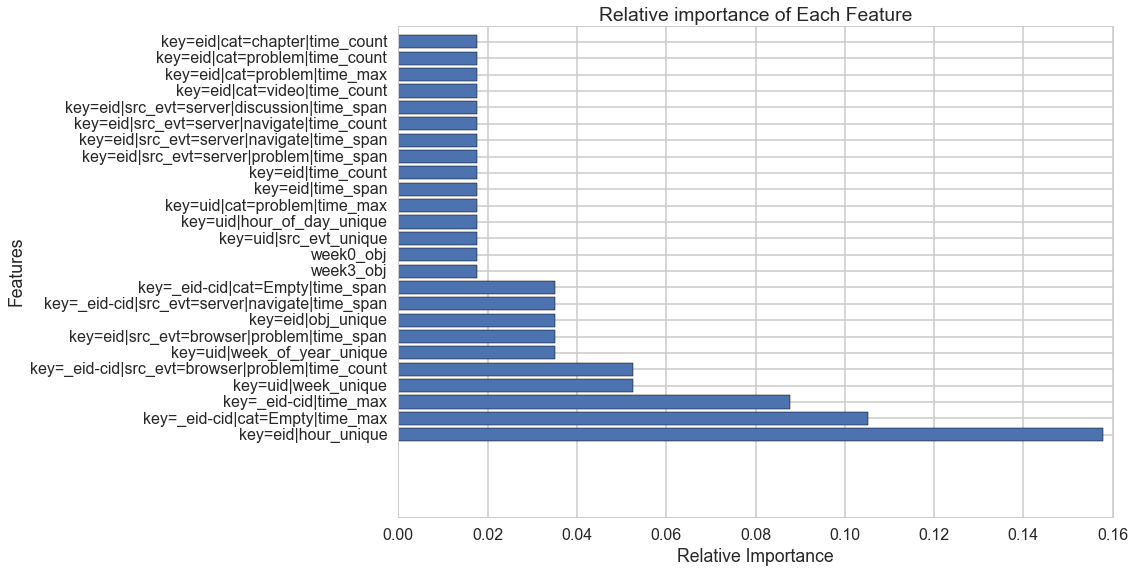

In [ ]:
#Using features that are derived from pandas corr function - ones that are correlated with the target variable
print("##########Ada boost Classifier model on features including enrollement details with hihgly correlated features with target############################")
estimators= [x for x in range(10, 60)]
clfAda = AdaBoostClassifier()
parameters = {"n_estimators": estimators}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda,parameters, data, 
                                                     features_high_corr,'churn_label',0, 
                                                     n_jobs = 4, score_func = 'f1')

print('AUC Score is ',GetAUCScore(clfAda))
feature_importances(clfAda, features_high_corr , 25)

#Using features that are derived from pandas corr function - ones that are correlated with the target variable

print("##########Ada boost Classifier model on features including enrollement details with hihgly correlated features with target and over sampling############################")
estimators= [x for x in range(10, 60)]
clfAda = AdaBoostClassifier()
parameters = {"n_estimators": estimators}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda,parameters, data, 
                                                     features_high_corr,'churn_label',0, 
                                                     n_jobs = 4, score_func = 'f1', over_sampling = True)

print('AUC Score is ',GetAUCScore(clfAda))
feature_importances(clfAda, features_high_corr , 25)

In [ ]:
print("##########SVM model on features which are highly correlated and over sampling############################")
parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
svc, Xtrain, ytrain, Xtest, ytest = do_classify(svc,parameters, data, 
                                                     features_high_corr,'churn_label',0, 
                                                     n_jobs = 4, score_func = 'f1' , over_sampling= True)
print ('AUC Score is ',GetAUCScore(svc))
feature_importances(svc, features_high_corr)



##########SVM model on features which are highly correlated and over sampling############################


In [65]:
def GetAUCScore(clf):
    y_score = [y[1] for y in clf.predict_proba(Xtest)]
    return roc_auc_score(ytest, y_score)

In [66]:
def feature_importances(clf , features , n =0):
    importance_list = clf.feature_importances_
    name_list = features
    importance_list, name_list = zip(*sorted(zip(importance_list, name_list) , reverse = True ))
    if n!=0:
        importance_list = importance_list[0:n]
        name_list = name_list[0:n]

    plt.barh(range(len(name_list)),importance_list,align='center')
    plt.yticks(range(len(name_list)),name_list)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Relative importance of Each Feature')
    plt.show()

# Conclusion
1. We see that Random forest and Ada boost ensemble gives us good  AUC (numbers explained later).
2. Important thing to note is - since the data is skewed towards dropouts, our prediction wrt non dropouts are not great. 
   I tried to to do stratified sampling to adjust the skewness but the results didnt improve much. 
3. One interesting observation for MOOC is how students (who will drop out) and students (who will complete the course) access      different resources of the course on the weekly basis.
4. Observing the feature importances we find that second week is the most crucial to determine whether a student will drop out      or not.
5. For feature selection - another approach was - to find the pearson's correlation between target variable and our features and    took the top 100. 


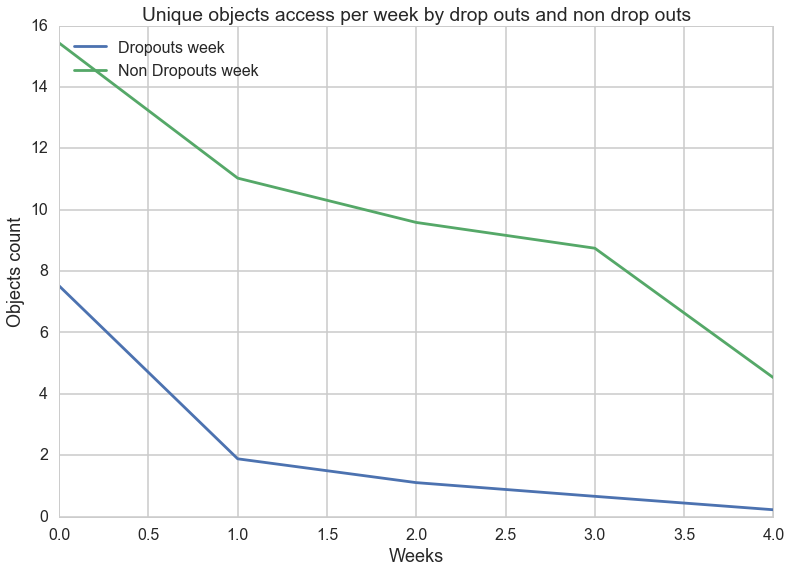

In [175]:
dropouts_week_obj_count = [dropout['week0_obj'].mean(),dropout['week1_obj'].mean() ,dropout['week2_obj'].mean(),dropout['week3_obj'].mean(),dropout['week4_obj'].mean() ]
no_dropout_obj_count = [no_dropout['week0_obj'].mean(),no_dropout['week1_obj'].mean() ,no_dropout['week2_obj'].mean(),no_dropout['week3_obj'].mean(),no_dropout['week4_obj'].mean() ]
weeks=[0,1,2,3,4]
fig, ax = plt.subplots()

ax.plot(weeks, dropouts_week_obj_count, label="Dropouts week")
ax.plot(weeks, no_dropout_obj_count, label=   "Non Dropouts week")

ax.legend(loc=2) # upper left corner
ax.set_xlabel('Weeks', fontsize=18)
ax.set_ylabel(r'Objects count', fontsize=18)
ax.set_title('Unique objects access per week by drop outs and non drop outs');

mean: 7.5163578535483
Standard Deviation: 7.640190987796511
Standard Error: 0.0247125994555
Margin of Error: 0.0484366949329
mean: 1.882727738776535
Standard Deviation: 5.879835206050711
Standard Error: 0.0190186361236
Margin of Error: 0.0372765268023
mean: 1.1069877904604473
Standard Deviation: 4.752291942262725
Standard Error: 0.015371538153
Margin of Error: 0.0301282147798
mean: 0.6603090572394095
Standard Deviation: 3.759881697102023
Standard Error: 0.0121615350361
Margin of Error: 0.0238366086708
mean: 0.22283717475230433
Standard Deviation: 2.2994979831051885
Standard Error: 0.00743784712922
Margin of Error: 0.0145781803733
mean: 15.430952285565482
Standard Deviation: 12.808361889799688
Standard Error: 0.0810704529691
Margin of Error: 0.15889808782
mean: 11.02860462321221
Standard Deviation: 14.182205525921912
Standard Error: 0.0897661883682
Margin of Error: 0.175941729202
mean: 9.58451183846801
Standard Deviation: 13.734089493857764
Standard Error: 0.0869298405187
Margin of Erro

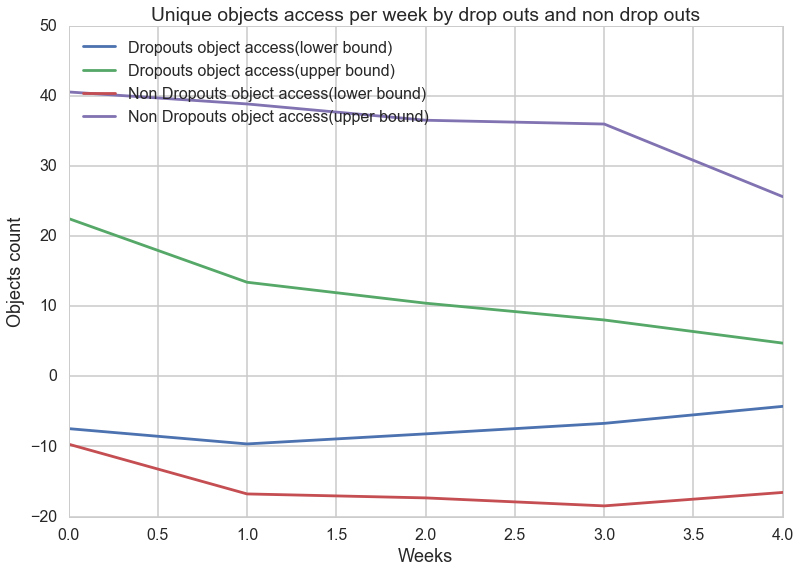

In [13]:
import statsmodels.stats.weightstats as sm
import scipy.stats as sp
weeks=[0,1,2,3,4]
fig, ax = plt.subplots()
features = ['week0_obj' , 'week1_obj', 'week2_obj', 'week3_obj', 'week4_obj']
dropout_l =[]
dropout_h =[]
no_dropout_l =[]
no_dropout_h =[]
for feature in features:
    d = dropout[feature]
    mean = loc=d.mean()
    std = np.std(d)
    se = std/np.sqrt(len(d))
    me = 1.96 * se
    (l, h ) = sp.norm.interval(.95, mean, scale=std)
    dropout_l.append(l)
    dropout_h.append(h)

ax.plot(weeks, dropout_l, label="Dropouts object access(lower bound)")
ax.plot(weeks, dropout_h, label="Dropouts object access(upper bound)")

dropout_l=[]
dropout_h=[]
for feature in features:
    d = no_dropout[feature]
    mean = loc=d.mean()
    std = np.std(d)
    se = std/np.sqrt(len(d))
    me = 1.96 * se
    (l, h ) = sp.norm.interval(.95, mean, scale=std)
    dropout_l.append(l)
    dropout_h.append(h)

ax.plot(weeks, dropout_l, label="Non Dropouts object access(lower bound)")
ax.plot(weeks, dropout_h, label="Non Dropouts object access(upper bound)")
ax.legend(loc=2) # upper left corner
ax.set_xlabel('Weeks', fontsize=18)
ax.set_ylabel(r'Objects count', fontsize=18)
ax.set_title('Unique objects access per week by drop outs and non drop outs');     

In [26]:
week_features = ['week0_obj' , 'week1_obj', 'week2_obj', 'week3_obj', 'week4_obj']
dropout_weekly_access = dropout[week_features]
no_dropout_weekly_access = no_dropout[week_features]

C:\Users\raga\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x131a8195f28>,
 'caps': [<matplotlib.lines.Line2D at 0x131a7bbf470>,
 'fliers': [<matplotlib.lines.Line2D at 0x131a815b7b8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x131a7d63e10>,
 'whiskers': [<matplotlib.lines.Line2D at 0x131a8195ac8>,
  <matplotlib.lines.Line2D at 0x131a81a7e10>]}

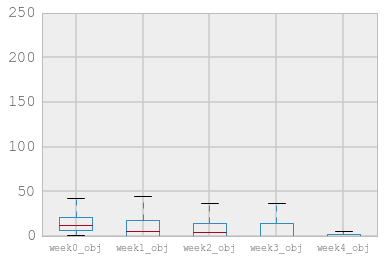

In [31]:
no_dropout_weekly_access.boxplot()

C:\Users\raga\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x131a9583cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x131a9565780>,
 'fliers': [<matplotlib.lines.Line2D at 0x131a9555fd0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x131a9555160>,
 'whiskers': [<matplotlib.lines.Line2D at 0x131a95837b8>,
  <matplotlib.lines.Line2D at 0x131a9146a90>]}

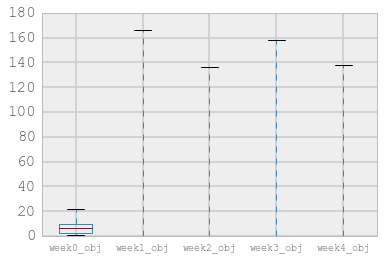

In [32]:
dropout_weekly_access.boxplot()

# Conclusion
1. We see that Random forest and Ada boost ensemble gives us good AUC (numbers explained later).
2. Important thing to note is - since the data is skewed towards dropouts, our prediction wrt non dropouts are not great. I        tried to to do stratified sampling to adjust the skewness but the results didnt improve much.
3. One interesting observation for MOOC is how students (who will drop out) and students (who will complete the course) access      different resources of the course on the weekly basis.
4. Observing the feature importances we find that second week is the most crucial to determine whether a student will drop out      or not.
5. For feature selection - another approach was - to find the pearson's correlation between target variable and our features and    took the top 100.
6. From the above graphs there is a clear way of difference between students who drop out and not drop out in terms of resources    being accessed on weekly basis.
7. One recommendation to MOOC is - when they see a steep weekly decrease in students' access on resources - try to contact the      student to see if some thing can be imporved.  